In [1]:
import numpy as np 
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from mlxtend.evaluate import bias_variance_decomp
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import matthews_corrcoef

import os  # disable tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
#original catalog
path = r'C:\Users\pedro\OneDrive - Universidade do Porto\Imagens\OneDrive - Universidade do Porto\Ambiente de Trabalho\UNI\Mestrado\1º semestre\Machine Learning\Projeto\dados\catalog.parquet'
catalog = pd.read_parquet(path)

In [3]:
catalog

,ID,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,1,150.477592,2.328928,14051.033584,24912.034028,0.019432,1.154464e-02,150.477638,2.328963,b'181_32',...,-9.140639,-9.116661,-9.089199,-9.063887,-9.050062,0.038461,0.038461,0.038461,0.038461,0.038461
1,2,150.477978,2.329170,14041.782916,24917.839703,0.102373,1.305541e-01,150.477974,2.329169,b'181_33',...,-8.737532,-8.618159,-8.478306,-8.337237,-8.213281,0.018737,0.018737,0.018737,0.018737,0.018737
2,3,150.477024,2.329483,NaN,NaN,NaN,NaN,150.477111,2.329667,b'181_34',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,150.477312,2.330573,14057.758498,24951.520772,0.098902,9.468231e-02,150.477316,2.330574,b'181_38',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,150.474793,2.332136,14118.162336,24989.006449,0.017773,3.539389e-02,150.474843,2.332179,b'181_39',...,-7.940726,-7.940726,-7.940726,-7.940726,-7.940726,0.042471,0.042471,0.042471,0.042471,0.042471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964501,964502,150.068793,2.870516,23853.815263,37909.784856,0.000065,8.288924e-05,150.068801,2.870500,b'283_5270',...,-9.524284,-9.095250,-8.751433,-8.005345,-8.005345,1.873661,1.873661,1.873661,1.873661,1.873661
964502,964503,150.072295,2.871735,23769.881726,37939.037182,0.000001,4.420735e-06,150.072305,2.871736,b'283_5271',...,-7.940726,-7.940726,-7.940726,-7.940726,-7.940726,1.129562,1.232992,1.334211,1.445236,1.543489
964503,964504,150.071539,2.874151,23787.988894,37997.043844,0.000004,6.963900e-07,150.071549,2.874164,b'283_5272',...,-10.023261,-9.878627,-9.719501,-9.560150,-9.434907,0.769145,0.817205,0.953520,1.319708,1.572936
964504,964505,150.088646,2.876782,23377.925486,38060.183349,0.098302,2.854818e-02,150.088643,2.876837,b'283_5273',...,-9.503490,-9.411257,-9.333571,-9.192708,-9.077335,0.042147,0.042147,0.042147,0.042147,0.042147


In [4]:
# filter out unreliable observations
catalog = catalog[catalog.filter(like='FLAG').eq(0).all(axis=1)] 

#stars and galaxies
catalog = catalog[catalog['lp_type'].isin([0, 1])]

In [5]:
label = ['lp_type']
cata = catalog.dropna(subset=label)
cata = cata.fillna(0).reset_index(drop=True)

In [6]:
def find_non_numeric_columns(df):
    non_numeric_columns = cata.select_dtypes(exclude=[np.number]).columns
    return non_numeric_columns

# Assuming df is your DataFrame
non_numeric_columns = find_non_numeric_columns(cata)

cata = cata.drop(columns=non_numeric_columns).astype(np.float32)

In [7]:
y = cata['lp_type']
X = cata.drop('lp_type', axis=1)

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [12]:
# Define the model
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(396,), kernel_regularizer=regularizers.l2(0.1)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))


model.add(Dense(1, activation='sigmoid'))

# Compile the model using RMSprop optimizer, binary-cross-entropy loss, and accuracy metrics
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                25408     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 29633 (115.75 KB)
Trainable params: 29633 (115.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
6335/6335 [==============================] - 11s 2ms/step - loss: 0.1608 - accuracy: 0.9875 - val_loss: 0.0463 - val_accuracy: 0.9887
Epoch 2/10
6335/6335 [==============================] - 9s 1ms/step - loss: 0.0433 - accuracy: 0.9907 - val_loss: 0.0382 - val_accuracy: 0.9913
Epoch 3/10
6335/6335 [==============================] - 9s 1ms/step - loss: 0.0376 - accuracy: 0.9920 - val_loss: 0.0372 - val_accuracy: 0.9923
Epoch 4/10
6335/6335 [==============================] - 9s 1ms/step - loss: 0.0355 - accuracy: 0.9926 - val_loss: 0.0365 - val_accuracy: 0.9921
Epoch 5/10
6335/6335 [==============================] - 10s 2ms/step - loss: 0.0343 - accuracy: 0.9927 - val_loss: 0.0316 - val_accuracy: 0.9934
Epoch 6/10
6335/6335 [==============================] - 11s 2ms/step - loss: 0.0334 - accuracy: 0.9928 - val_loss: 0.0339 - val_accuracy: 0.9926
Epoch 7/10
6335/6335 [==============================] - 11s 2ms/step - loss: 0.0330 - accuracy: 0.9931 - val_loss: 0.0353 - val_accur

In [14]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9942577481269836


3168/3168 [==============================] - 2s 719us/step


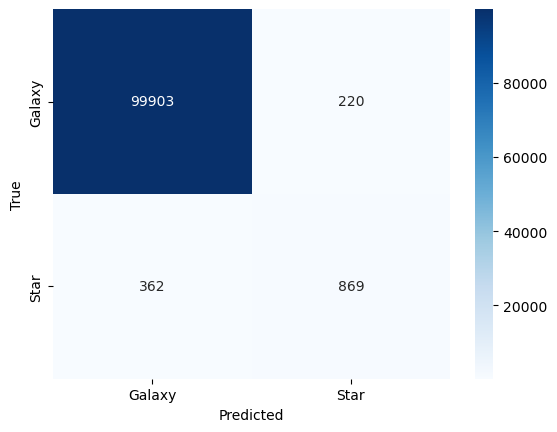

In [15]:
# Make predictions on the test data using the trained neural network model
y_prob = model.predict(X_test)

# Convert predicted probabilities to binary predictions based on a threshold of 0.5
y_pred = (y_prob > 0.5).astype(int)

# Compute the confusion matrix to evaluate the model's performance
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Galaxy', 'Star'], yticklabels=['Galaxy', 'Star'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
mcc = matthews_corrcoef(y_test, y_pred)

print('Matthew\'s Correlation Coefficient (MCC): %.3f' % mcc)

Matthew's Correlation Coefficient (MCC): 0.748
